In [9]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from textblob import TextBlob  # For basic sentiment analysis
import re


# IDENTIFYING FAKE REVIEWS



## 1) LOADING THE DATASET

In [10]:
import pandas as pd

# Path to the TSV file
file_path = '/kaggle/input/amazon-us-customer-reviews-dataset/amazon_reviews_us_Watches_v1_00.tsv'

# Load the TSV file, handling any bad lines
try:
    # Use on_bad_lines='skip' to skip lines with too many fields
    df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')  # Specify the separator
    print("Data loaded successfully!")
    
    # Print the columns
    print("Columns in the dataset:")
    print(df.columns.tolist())
    
    # Display the first few rows of the DataFrame
    print(df.head())
except Exception as e:
    print("Error loading data:", e)


Data loaded successfully!
Columns in the dataset:
['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
  marketplace  customer_id       review_id  product_id  product_parent  \
0          US      3653882  R3O9SGZBVQBV76  B00FALQ1ZC       937001370   
1          US     14661224   RKH8BNC3L5DLF  B00D3RGO20       484010722   
2          US     27324930  R2HLE8WKZSU3NL  B00DKYC7TK       361166390   
3          US      7211452  R31U3UH5AZ42LL  B000EQS1JW       958035625   
4          US     12733322  R2SV659OUJ945Y  B00A6GFD7S       765328221   

                                       product_title product_category  \
0  Invicta Women's 15150 "Angel" 18k Yellow Gold ...          Watches   
1  Kenneth Cole New York Women's KC4944 Automatic...          Watches   
2  Ritche 22mm Black Stainless Steel Bracelet Wa

## 2) Calculating Fake Score 

    1) Sentiment Analysis - ( Score increases if there is a mismatch in Review sentiment and the rating )
    2) Spam Detection     - ( Detects Spam and increases the score )
    3) Review Length      - ( Too Short and Too Long Reviews will have a slight increase in score )
    4) Verified Purchase  - ( Unverified Purchase will increase the score )

In [11]:
from textblob import TextBlob

# Feature: Length of the review
df['review_length'] = df['review_body'].apply(lambda x: len(str(x).split()))

# Feature: Check if the review is a verified purchase
df['is_verified'] = df['verified_purchase'].apply(lambda x: 1 if x == 'Y' else 0)

# Feature: Number of reviews from the same user
user_review_count = df['customer_id'].value_counts().to_dict()
df['user_review_count'] = df['customer_id'].apply(lambda x: user_review_count.get(x, 0))

# Feature: Sentiment Analysis Score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment_score'] = df['review_body'].apply(lambda x: get_sentiment(str(x)))

# Feature: Check if sentiment matches the star rating
def sentiment_matches_rating(sentiment, rating):
    if rating >= 4 and sentiment < 0:
        return 1
    elif rating <= 2 and sentiment > 0:
        return 1
    return 0

df['sentiment_mismatch'] = df.apply(lambda row: sentiment_matches_rating(row['sentiment_score'], row['star_rating']), axis=1)

# Feature: Check if the user is spamming reviews (based on user_review_count)
def is_user_spammer(review_count):
    return 1 if review_count > 10 else 0

df['user_spammer'] = df['user_review_count'].apply(lambda x: is_user_spammer(x))

In [12]:
# Define weights for each feature
weights = {
    'review_length': 0.2,
    'is_verified': -0.3,
    'sentiment_mismatch': 0.4,
    'user_spammer': 0.5
}

# Calculate final heuristic score
def calculate_fake_score(row, weights):
    score = 0
    
    # Check review length
    if row['review_length'] < 5 or row['review_length'] > 150:
        score += weights['review_length']
    
    # Adjust score based on verification status
    score += weights['is_verified'] * (1 - row['is_verified'])
    
    # Add sentiment mismatch score
    score += weights['sentiment_mismatch'] * row['sentiment_mismatch']
    
    # Add score for spammy users
    score += weights['user_spammer'] * row['user_spammer']
    
    return score

# Apply score calculation
df['fake_score'] = df.apply(lambda row: calculate_fake_score(row, weights), axis=1)

# Set a threshold for identifying fake reviews (this can be adjusted later)
threshold = 0.5
df['is_fake'] = df['fake_score'].apply(lambda x: 1 if x >= threshold else 0)

# TEST AND TRAIN MODEL FOR FAKE REVIEW

## Preprocessing the fake_score to have equal weights

In [70]:
import pandas as pd

# Assuming df is your DataFrame and it has been loaded and cleaned
# Display the current counts
print("Original class distribution:")
print(df['is_fake'].value_counts())

# Count of minority class
count_minority = df['is_fake'].value_counts()[1]

# Filter out the majority class
majority_class = df[df['is_fake'] == 0]

# Randomly sample from the majority class
majority_class_sampled = majority_class.sample(n=count_minority, random_state=42)

# Combine with minority class
balanced_df = pd.concat([majority_class_sampled, df[df['is_fake'] == 1]])

# Shuffle the resulting DataFrame (optional)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("\nNew class distribution:")
print(balanced_df['is_fake'].value_counts())


'''import pandas as pd

# Assuming df is your DataFrame and it has been loaded and cleaned
# Display the current counts
print("Original class distribution:")
print(df['is_fake'].value_counts())

# Count of minority class
count_minority = df['is_fake'].value_counts()[1]

# Set the desired count for the majority class (twice the minority class count)
desired_count_majority = count_minority * 2

# Filter out the majority class
majority_class = df[df['is_fake'] == 0]

# Randomly sample from the majority class
majority_class_sampled = majority_class.sample(n=desired_count_majority, random_state=42)

# Combine with the minority class
balanced_df = pd.concat([majority_class_sampled, df[df['is_fake'] == 1]])

# Shuffle the resulting DataFrame (optional)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("\nNew class distribution:")
print(balanced_df['is_fake'].value_counts())
'''

Original class distribution:
is_fake
0    927006
1     33198
Name: count, dtype: int64

New class distribution:
is_fake
1    33198
0    33198
Name: count, dtype: int64


'import pandas as pd\n\n# Assuming df is your DataFrame and it has been loaded and cleaned\n# Display the current counts\nprint("Original class distribution:")\nprint(df[\'is_fake\'].value_counts())\n\n# Count of minority class\ncount_minority = df[\'is_fake\'].value_counts()[1]\n\n# Set the desired count for the majority class (twice the minority class count)\ndesired_count_majority = count_minority * 2\n\n# Filter out the majority class\nmajority_class = df[df[\'is_fake\'] == 0]\n\n# Randomly sample from the majority class\nmajority_class_sampled = majority_class.sample(n=desired_count_majority, random_state=42)\n\n# Combine with the minority class\nbalanced_df = pd.concat([majority_class_sampled, df[df[\'is_fake\'] == 1]])\n\n# Shuffle the resulting DataFrame (optional)\nbalanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)\n\n# Display new class distribution\nprint("\nNew class distribution:")\nprint(balanced_df[\'is_fake\'].value_counts())\n'

In [71]:

balanced_df = balanced_df[['review_body', 'is_fake']]

# Display the cleaned data
print(balanced_df.head())

                                         review_body  is_fake
0  A little disappointed. The watch was larger th...        1
1  It's a OK product, compatible to several G-sho...        0
2  Great watch! My dog loved it too, as he chewed...        0
3  quality is very cheap, belt is made of some ch...        0
4                                         cool watch        0


In [72]:
print(df['is_fake'].value_counts())
print(balanced_df['is_fake'].value_counts())

is_fake
0    927006
1     33198
Name: count, dtype: int64
is_fake
1    33198
0    33198
Name: count, dtype: int64


In [73]:
y = balanced_df['is_fake']


In [74]:
balanced_df['review_body'] = balanced_df['review_body'].fillna('')
# Text cleaning function
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()  # Convert to lowercase

# Apply the cleaning function to the review body
balanced_df['cleaned_text'] = balanced_df['review_body'].apply(clean_text)

## Cleaning the Review text with TFIDF

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF to convert text into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf_vectorizer.fit_transform(balanced_df['cleaned_text'])  # Use cleaned_text for vectorization

# The label will be our target
y = balanced_df['is_fake']

## TRAINING A RANDOM FOREST ALGORITHM 

In [77]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model - Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Optional - Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[5263 1377]
 [2270 4370]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6640
           1       0.76      0.66      0.71      6640

    accuracy                           0.73     13280
   macro avg       0.73      0.73      0.72     13280
weighted avg       0.73      0.73      0.72     13280

Accuracy: 0.7254


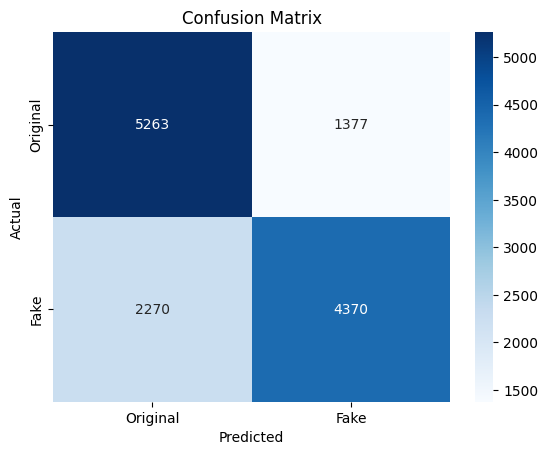

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Fake'], yticklabels=['Original', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()